In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils.utils import *

random.seed(1)

# Autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
data_folder = "data"

image_files = [f for f in os.listdir(data_folder) if f.endswith("png")]

### Chose a random image to train a neural representation on

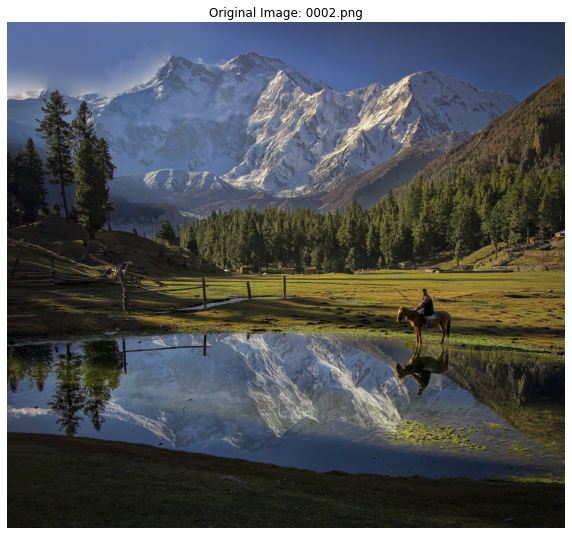

Image dimensions: 1848x2040, 3 channels


In [3]:
# Choose a random image to train on
img_file_path = '0002.png'
img_path = os.path.join(data_folder, img_file_path)
img_original = Image.open(img_path)

# Convert image to numpy array
img_np_original = np.array(img_original)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_original)
plt.axis("off")
plt.title(f"Original Image: {img_file_path}")
plt.show()

# Get image dimensions
height_target, width_target, channels = img_np_original.shape
print(f"Image dimensions: {height_target}x{width_target}, {channels} channels")

Downsize factor: 3


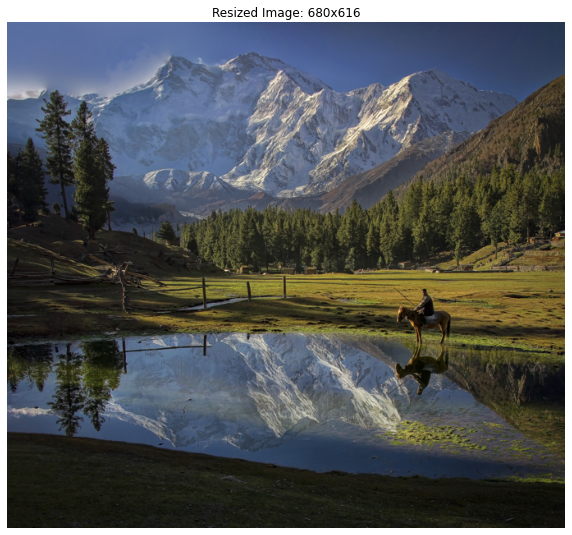

Resized image dimensions: 616x680, 3 channels


In [4]:
# Now we will downsize the original image to a smaller resolution using a random integer factor
downsize_factor = 3
print(f"Downsize factor: {downsize_factor}")
img_resized = img_original.resize((width_target // downsize_factor, height_target // downsize_factor))

# convert image to numpy array
img_np_resized = np.array(img_resized)

# Display the resized image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_resized)
plt.axis("off")
plt.title(f"Resized Image: {width_target // downsize_factor}x{height_target // downsize_factor}")
plt.show()

# Print the resolution of the new image
height_resized, width_resized, channels = img_np_resized.shape
print(f"Resized image dimensions: {height_resized}x{width_resized}, {channels} channels")

### We will next normalize the pixels to have values between 0 and 1

In [5]:
# Normalize the resized image
img_np_resized_standardized = img_np_resized / 255.0  # Normalize to [0, 1]

In [6]:
# Print the mean of the resized image
print(f"Resized image mean: {np.mean(img_np_resized_standardized, axis=(0, 1))}")
print(f"Resized image std: {np.std(img_np_resized_standardized, axis=(0, 1))}")

Resized image mean: [0.27551185 0.29086209 0.29602895]
Resized image std: [0.15515677 0.15763278 0.2025867 ]


### Normalize the coordinates of the image to be between 0 and 1.

In [7]:
normalized_coordinates = get_normalized_coordinates(height_resized, width_resized)
pixel_values = img_np_resized_standardized.reshape(-1, channels)

# Check shapes
print(f"Normalized coordinates shape: {normalized_coordinates.shape}")
print(f"Pixel values shape: {pixel_values.shape}")

Normalized coordinates shape: (418880, 2)
Pixel values shape: (418880, 3)


### Create the dataset and dataloader for the downsampled image

In [8]:
# Create dataset and dataloader
dataset = ImageDataset(normalized_coordinates, pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

  1%|          | 1/100 [00:07<11:58,  7.26s/it]

Epoch 0, Loss: 0.047069


 11%|█         | 11/100 [01:19<10:14,  6.90s/it]

Epoch 10, Loss: 0.012091


 21%|██        | 21/100 [02:26<08:54,  6.77s/it]

Epoch 20, Loss: 0.011330


 31%|███       | 31/100 [04:10<11:26,  9.95s/it]

Epoch 30, Loss: 0.010976


 41%|████      | 41/100 [05:37<07:40,  7.80s/it]

Epoch 40, Loss: 0.010825


 51%|█████     | 51/100 [06:57<07:25,  9.10s/it]

Epoch 50, Loss: 0.010710


 61%|██████    | 61/100 [08:54<07:08, 10.98s/it]

Epoch 60, Loss: 0.010679


 71%|███████   | 71/100 [10:39<05:17, 10.94s/it]

Epoch 70, Loss: 0.010621


 81%|████████  | 81/100 [12:31<03:07,  9.88s/it]

Epoch 80, Loss: 0.010537


 91%|█████████ | 91/100 [14:02<01:22,  9.20s/it]

Epoch 90, Loss: 0.010478


100%|██████████| 100/100 [15:16<00:00,  9.17s/it]


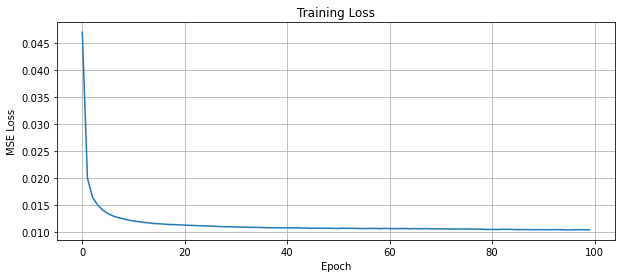

In [9]:
# Create and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.MSELoss()
model = INRModel(input_dim=2, output_dim=channels, hidden_dim=128, num_layers=3, dropout_rate=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = model.train_model(dataloader, num_epochs=100, lr=1e-3, device=device, criterion = criterion, optimizer = optimizer)

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

Max and Min values of pred_pixels: 0.8860419988632202, 5.6448534451192245e-06


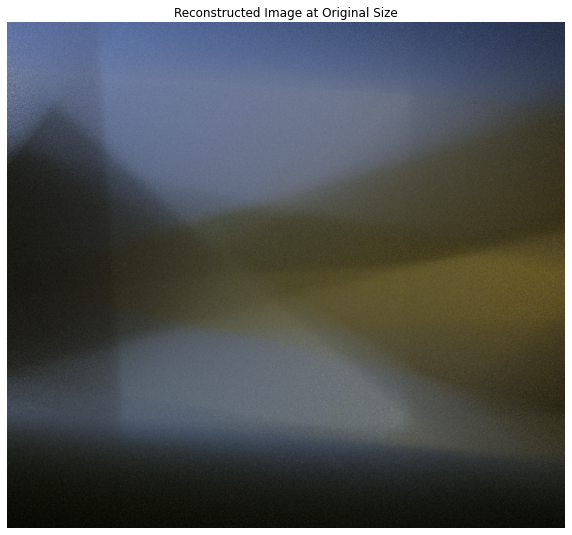

Downsized image shape: (616, 680, 3)
Reconstructed image shape: (1848, 2040, 3)
Original image shape: (1848, 2040, 3)


In [10]:
# Generate normalized coordinates for the original image size
target_coords_normalized = get_normalized_coordinates(height_target, width_target)

# Convert to PyTorch tensor
target_coords_tensor = torch.from_numpy(target_coords_normalized).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

# Denormalize the RGB values using the mean and std of the resized image (i.e the training data)
reconstructed_img_reshaped_normalized = pred_pixels.reshape(height_target, width_target, channels)
# Convert to integer type and denormalize
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
# IMPORTANT: Need to round the pixels to the nearest integer value and clip them to [0, 255] range
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)

# Display the reconstructed image
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_img_reshaped_denormalized)
plt.title('Reconstructed Image at Original Size')
plt.axis('off')
plt.show()

# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {img_np_resized.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {img_np_original.shape}")